In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# import statsmodels.api as sm
# import statsmodels.stats.diagnostic as smd
from sklearn.linear_model import LinearRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import Ridge
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.gofplots import qqplot
from sklearn.pipeline import Pipeline
# from yellowbrick.regressor import ResidualsPlot
import scipy.stats as stats
import statsmodels.stats.diagnostic as diag
from scipy.stats import normaltest

import seaborn as sns
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_absolute_error
from sklearn import tree

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


train_data = pd.read_csv("csv/train.csv",  encoding='latin-1')


# Arboles de decision

## árbol de regresión para predecir el precio de las casas usando todas las variables. 

In [55]:
train_data.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

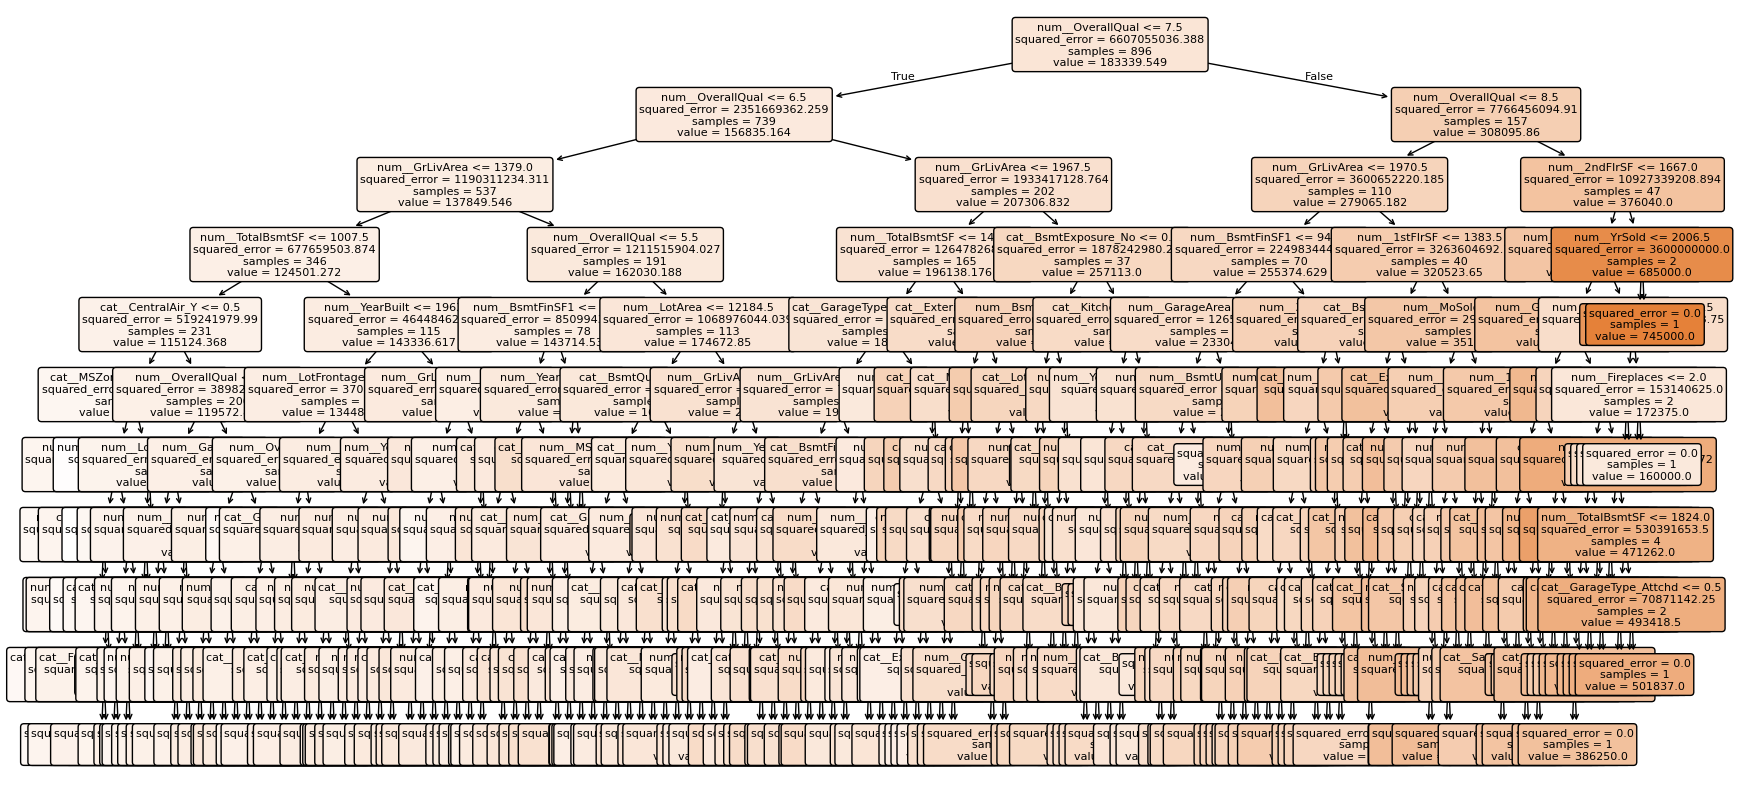

In [56]:
X_full = train_data.drop(columns=["Id", "SalePrice"])
y_full = train_data["SalePrice"] # (objetivo)

# Identificar columnas numéricas y categóricas

num_features = X_full.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X_full.select_dtypes(include=['object']).columns.tolist()

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),  # Pasar numéricas sin cambios
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # OneHot para categóricas
    ]
)

# Aplicar la transformación a los datos
X_transformed = preprocessor.fit_transform(X_full)

# Convertir el resultado a un DataFrame
if hasattr(X_transformed, "toarray"): 
    X_transformed = X_transformed.toarray()

X_transformed_df = pd.DataFrame(X_transformed, columns=preprocessor.get_feature_names_out())

# Eliminar filas con valores nulos
X_transformed_df = X_transformed_df.dropna()
y_filtered = y_full.loc[X_transformed_df.index]

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y_filtered, test_size=0.2, random_state=42)

# Entrenar el árbol de regresión con todas las variables transformadas
reg_tree_full = DecisionTreeRegressor(max_depth=10, random_state=42)
reg_tree_full.fit(X_train, y_train)

# Hacer predicciones en el conjunto de prueba
y_pred_full = reg_tree_full.predict(X_test)

# Evaluar el rendimiento del modelo
mae = mean_absolute_error(y_test, y_pred_full)
rmse = np.sqrt(mean_squared_error(y_test, y_pred_full))
r2 = r2_score(y_test, y_pred_full)

# Mostrar métricas de evaluación
mae, rmse, r2

plt.figure(figsize=(20, 10))
tree.plot_tree(reg_tree_full, feature_names=preprocessor.get_feature_names_out(), filled=True, rounded=True, fontsize=8)
plt.show()


# 3 modelos más, cambiando el parámetro de la profundidad del árbol

[{'Depth': 4, 'MAE': 28620.02308279287, 'RMSE': np.float64(42030.71045976078), 'R²': 0.7760227297576276}, {'Depth': 6, 'MAE': 26487.921427493948, 'RMSE': np.float64(38951.39913977072), 'R²': 0.807639184516113}, {'Depth': 10, 'MAE': 26435.67571255905, 'RMSE': np.float64(39131.28632820905), 'R²': 0.8058583422254149}, {'Depth': 15, 'MAE': 27249.1706993007, 'RMSE': np.float64(39814.805158058436), 'R²': 0.7990168379633987}]


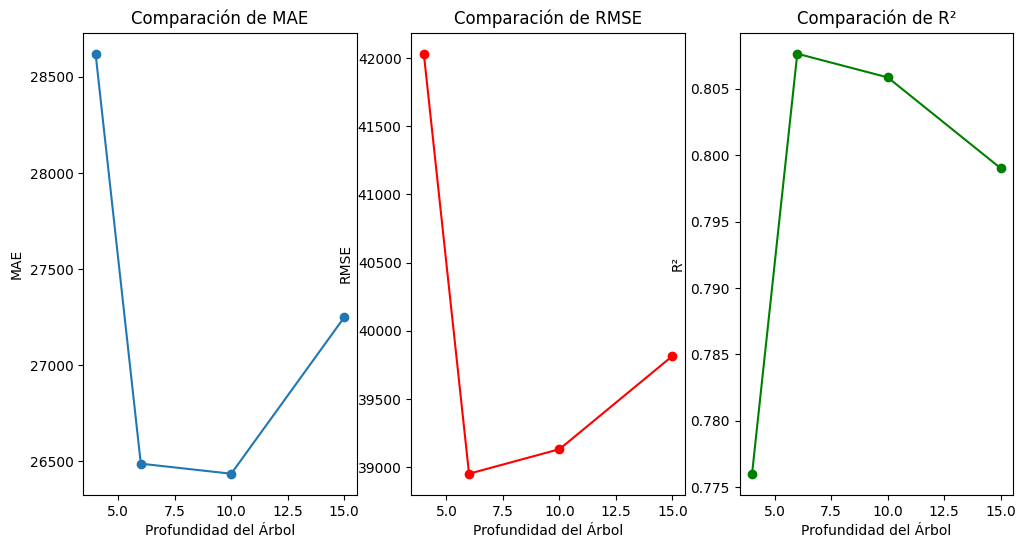

In [57]:
depths = [4, 6, 10, 15]  # Profundidades a evaluar
results = []

for depth in depths:
    # Entrenar el árbol de regresión con la profundidad actual
    reg_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    reg_tree.fit(X_train, y_train)

    # Hacer predicciones
    y_pred = reg_tree.predict(X_test)

    # Evaluar el modelo
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)

    # Guardar resultados
    results.append({"Depth": depth, "MAE": mae, "RMSE": rmse, "R²": r2})

# Convertir resultados a DataFrame para visualización
results_df = pd.DataFrame(results)

# Graficar los resultados
plt.figure(figsize=(12, 6))

# Gráfico de MAE
plt.subplot(1, 3, 1)
plt.plot(results_df["Depth"], results_df["MAE"], marker='o', linestyle='-')
plt.xlabel("Profundidad del Árbol")
plt.ylabel("MAE")
plt.title("Comparación de MAE")

# Gráfico de RMSE
plt.subplot(1, 3, 2)
plt.plot(results_df["Depth"], results_df["RMSE"], marker='o', linestyle='-', color='r')
plt.xlabel("Profundidad del Árbol")
plt.ylabel("RMSE")
plt.title("Comparación de RMSE")

# Gráfico de R²
plt.subplot(1, 3, 3)
plt.plot(results_df["Depth"], results_df["R²"], marker='o', linestyle='-', color='g')
plt.xlabel("Profundidad del Árbol")
plt.ylabel("R²")
plt.title("Comparación de R²")
print(results)


- El MAE y el RMSE son más bajos en profundidad 6 y 10, lo que indica que estos modelos hacen predicciones más precisas. 
- El modelo con profundidad 6 tiene el mayor R² (0.808), lo que significa que explica mejor la variabilidad de los precios. 
- Aumentar la profundidad a 10 no mejora significativamente el R², lo que sugiere que no hay un gran beneficio en hacer el árbol más complejo.
- Con profundidad 15, el R² disminuye (0.799), lo que confirma que el modelo podría estar sobre ajustado y perdiendo capacidad de generalización. 
- El modelo con profundidad 6 es el más equilibrado. 

# Comparando arboles de regresion VS MRL de la hoja anterior

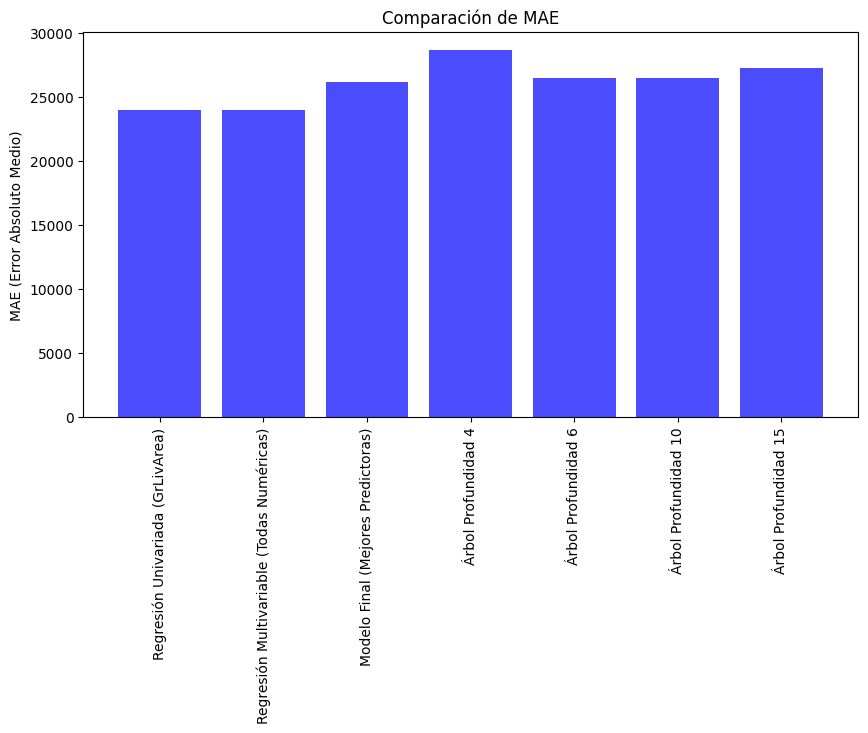

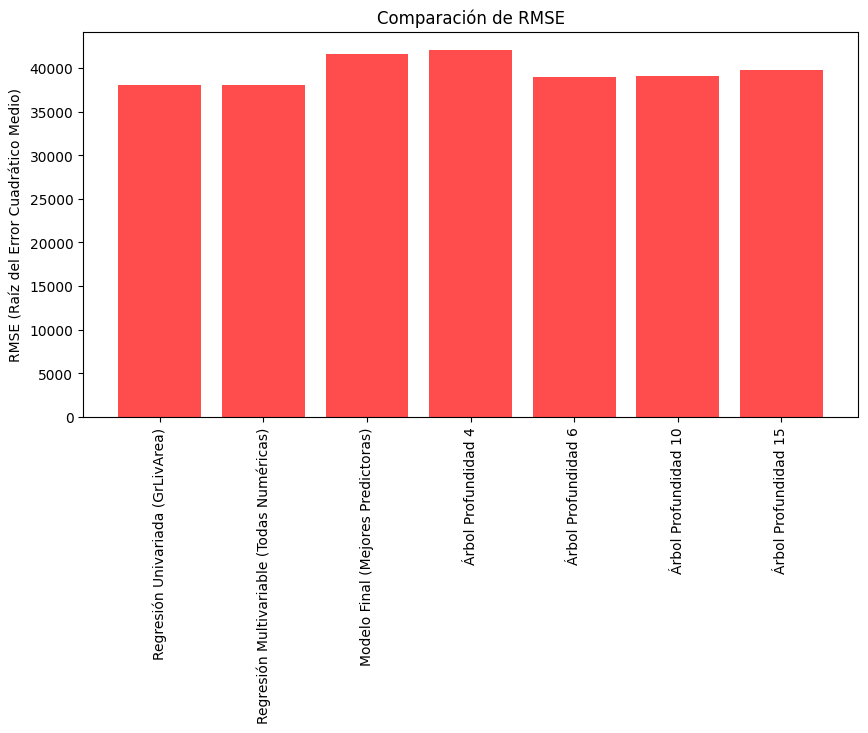

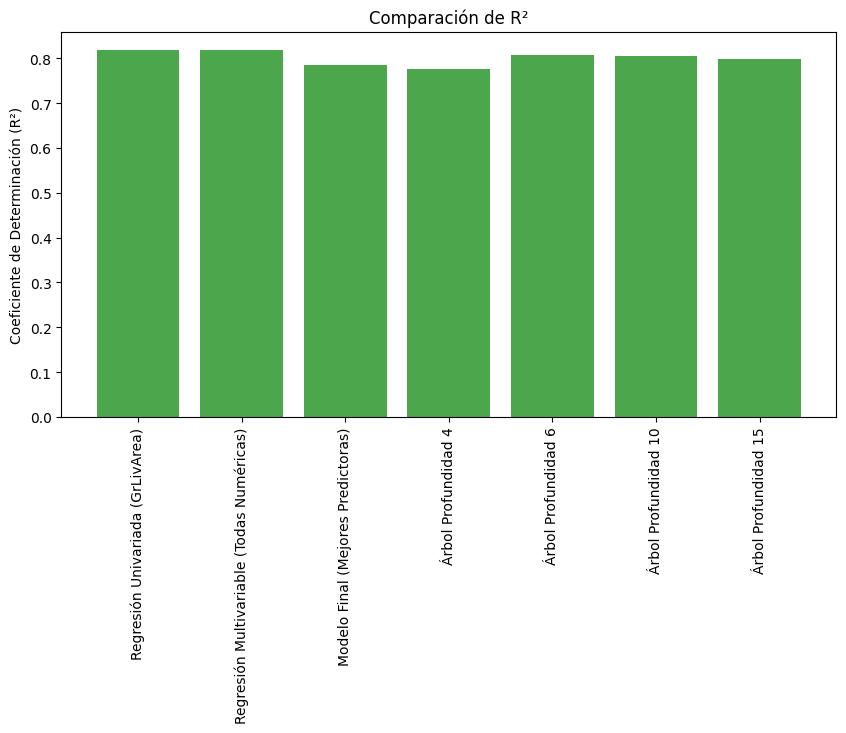

In [58]:
linear_models = pd.DataFrame({
    "Modelo": [
        "Regresión Univariada (GrLivArea)",
        "Regresión Multivariable (Todas Numéricas)",
        "Modelo Final (Mejores Predictoras)"
    ],
    "MAE": [23967.66, 23967.66, 26126.92],
    "RMSE": [38098.05, 38098.05, 41564.97],  # de regresion_lineal.ipynb
    "R²": [0.818, 0.818, 0.784]
})

tree_models = pd.DataFrame([
    {"Modelo": f"Árbol Profundidad {d['Depth']}", "MAE": d["MAE"], "RMSE": d["RMSE"], "R²": d["R²"]}
    for d in [
        {'Depth': 4, 'MAE': 28620.02, 'RMSE': 42030.71, 'R²': 0.776},
        {'Depth': 6, 'MAE': 26487.92, 'RMSE': 38951.40, 'R²': 0.808},
        {'Depth': 10, 'MAE': 26435.68, 'RMSE': 39131.29, 'R²': 0.806},
        {'Depth': 15, 'MAE': 27249.17, 'RMSE': 39814.81, 'R²': 0.799}
    ]
])

# Unir ambos conjuntos de modelos
all_models = pd.concat([linear_models, tree_models], ignore_index=True)

# Graficar comparación de MAE, RMSE y R²
# fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Gráfico de MAE
plt.figure(figsize=(10, 5))
plt.bar(all_models["Modelo"], all_models["MAE"], color='blue', alpha=0.7)
plt.title("Comparación de MAE")
plt.ylabel("MAE (Error Absoluto Medio)")
plt.xticks(rotation=90)
plt.show()

# Gráfico de RMSE
plt.figure(figsize=(10, 5))
plt.bar(all_models["Modelo"], all_models["RMSE"], color='red', alpha=0.7)
plt.title("Comparación de RMSE")
plt.ylabel("RMSE (Raíz del Error Cuadrático Medio)")
plt.xticks(rotation=90)
plt.show()

# Gráfico de R²
plt.figure(figsize=(10, 5))
plt.bar(all_models["Modelo"], all_models["R²"], color='green', alpha=0.7)
plt.title("Comparación de R²")
plt.ylabel("Coeficiente de Determinación (R²)")
plt.xticks(rotation=90)
plt.show()


# Análisis de los resultados:

Regresión Lineal vs. Árbol de Decisión

- La regresión lineal multivariable (todas las variables numéricas) tuvo el mejor desempeño en términos de MAE y RMSE.
- La regresión univariada (solo GrLivArea) y la multivariable tienen el mejor R² (~0.818), lo que significa que explican más variabilidad en los precios de las casas.

## Conclusión: ¿Cuál modelo es mejor?
- La regresión lineal multivariable sigue siendo el mejor modelo en términos de precisión general.
- El árbol de decisión con profundidad 6 es la mejor alternativa dentro de los árboles de regresión,


#  Una variable respuesta que le permita clasificar las casas en Económicas, Intermedias o Caras, se llamara "PriceCategory"

In [59]:
saleprice_summary = train_data["SalePrice"].describe()

# Calcular percentiles para definir los rangos de clasificación
q1 = train_data["SalePrice"].quantile(0.33)  # 33% más barato
q2 = train_data["SalePrice"].quantile(0.66)  # 66% intermedio
print(q1, q2,  train_data["SalePrice"].max())

# Crear la nueva variable categórica basada en los percentiles
train_data["PriceCategory"] = pd.cut(train_data["SalePrice"], 
                             bins=[train_data["SalePrice"].min(), q1, q2, train_data["SalePrice"].max()], 
                             labels=["Económica", "Intermedia", "Cara"], 
                             include_lowest=True)

# Mostrar resumen de la variable categórica creada
train_data[["PriceCategory", "SalePrice"]]
train_data["PriceCategory"].value_counts(), saleprice_summary


139000.0 189893.00000000006 755000


(PriceCategory
 Cara          497
 Económica     483
 Intermedia    480
 Name: count, dtype: int64,
 count      1460.000000
 mean     180921.195890
 std       79442.502883
 min       34900.000000
 25%      129975.000000
 50%      163000.000000
 75%      214000.000000
 max      755000.000000
 Name: SalePrice, dtype: float64)

# Distribución de categorías:

- Casas Económicas: 483
- Casas Intermedias: 480
- Casas Caras: 497

# Rangos Utilizados:

- Económicas: ≤ $129,975 (33% más barato)
- Intermedias: $129,975 - $214,000
- Caras: ≥ $214,000 (33% más caro)


# Arbol de clasificacion

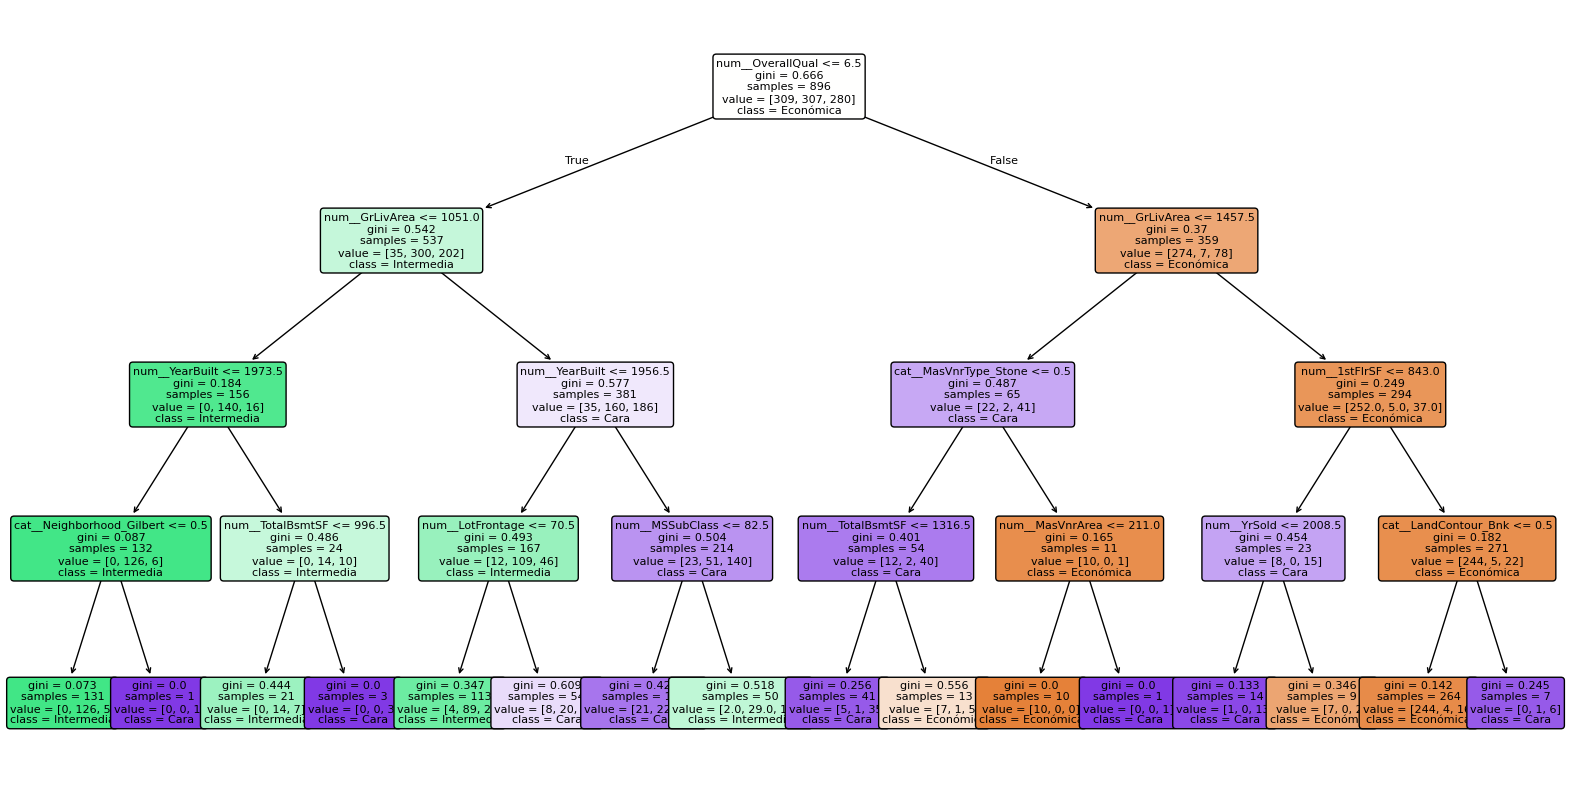

In [60]:
X = train_data.drop(columns=["Id", "SalePrice", "PriceCategory"])
y = train_data["PriceCategory"] # variable respuesta

# Identificar columnas numéricas y categóricas
num_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
cat_features = X.select_dtypes(include=['object']).columns.tolist()

# Aplicar transformación con OneHotEncoder para variables categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', num_features),  # Variables numéricas sin cambios
        ('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)  # OneHotEncoder para categóricas
    ]
)

X_transformed = preprocessor.fit_transform(X)

# Convertir a DataFrame
X_transformed_df = pd.DataFrame(X_transformed.toarray() if hasattr(X_transformed, "toarray") else X_transformed, 
                                columns=preprocessor.get_feature_names_out())

# Ahora, eliminar las filas con valores nulos después de la transformación
X_transformed_df = X_transformed_df.dropna()

y_filtered = y.loc[X_transformed_df.index]

# Dividir en conjunto de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X_transformed_df, y_filtered, test_size=0.2, random_state=42)

# Entrenar el árbol de clasificación
clf_tree = DecisionTreeClassifier(max_depth=4, random_state=42)
clf_tree.fit(X_train, y_train)

# Hacer predicciones
y_pred = clf_tree.predict(X_test) #usar para determinar eficiencia del algoritmo

plt.figure(figsize=(20, 10))
tree.plot_tree(clf_tree, feature_names=X_transformed_df.columns, class_names=["Económica", "Intermedia", "Cara"],
               filled=True, rounded=True, fontsize=8)
plt.show()




# Eficiencia del algoritmo para clasificar

In [61]:
# Hacer predicciones
y_pred = clf_tree.predict(X_test)

# Evaluar precision
accuracy = accuracy_score(y_test, y_pred)
print(f"Precisión del modelo: {accuracy:.2f}")

report = classification_report(y_test, y_pred)
print(report)



Precisión del modelo: 0.68
              precision    recall  f1-score   support

        Cara       0.84      0.78      0.81        89
   Económica       0.61      0.73      0.67        56
  Intermedia       0.57      0.54      0.55        80

    accuracy                           0.68       225
   macro avg       0.67      0.68      0.67       225
weighted avg       0.69      0.68      0.68       225



### Casas Caras:
Precisión: 84% (cuando predice "Cara", es correcto el 84% de las veces).
Recall: 78% (captura el 78% de todas las casas caras reales).
F1-Score: 81% (promedio de precisión y recall, buen balance).

### Casas Económicas:
Precisión: 61% (cuando dice "Económica", es correcto el 61% de las veces).
Recall: 73% (identifica correctamente el 73% de las casas económicas reales).
F1-Score: 67% (rendimiento medio, mejor en recall que en precisión).

### Casas Intermedias:
Precisión: 57% (cuando predice "Intermedia", es correcto el 57% de las veces).
Recall: 54% (captura el 54% de todas las casas intermedias reales).
F1-Score: 55% (rendimiento más bajo entre las tres categorías).

El modelo funciona bien para clasificar casas caras, tiene desempeño aceptable en casas económicas, pero falla en las casas intermedias.

# Matriz de confusión para el árbol de clasificación

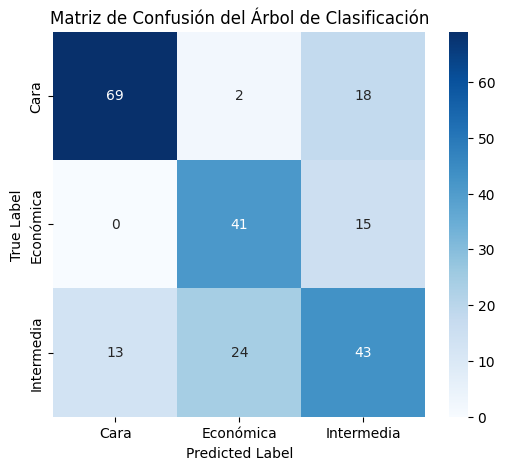

Matriz de Confusión:
            Cara  Económica  Intermedia
Cara          69          2          18
Económica      0         41          15
Intermedia    13         24          43


In [62]:
# Generar la matriz de confusión
cm = confusion_matrix(y_test, y_pred)

# Crear un heatmap para visualizar la matriz de confusión
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=clf_tree.classes_, yticklabels=clf_tree.classes_)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Matriz de Confusión del Árbol de Clasificación")
plt.show()

# Convertir matriz de confusión a DataFrame para análisis
cm_df = pd.DataFrame(cm, index=clf_tree.classes_, columns=clf_tree.classes_)
print("Matriz de Confusión:")
print(cm_df)


### Efectividad Global
Correctas: 69 (Caras), 41 (Económicas), 43 (Intermedias).
Errores comunes: Confusión entre Intermedias y Económicas (24 errores) y Intermedias y Caras (13 errores).
### Dónde se Equivocó Más
Casas intermedias: Se confunden con económicas (24) y caras (13) → El modelo no diferencia bien esta categoría.
Casas caras como intermedias (18) → Puede subestimar su valor.
### Dónde se Equivocó Menos
Casas económicas nunca fueron clasificadas como caras (0 errores).
Casas caras casi nunca se confundieron con económicas (2 errores).
### Impacto de los Errores
Errores entre clases vecinas son comunes (económica ↔ intermedia, intermedia ↔ cara).
Los errores graves (económica ↔ cara) son mínimos.

# Modelo usando validación cruzada

In [122]:
# Validación cruzada con 5 folds
cv_scores = cross_val_score(clf_tree, X_train, y_train, cv=5)

print("Cross-validation scores:", cv_scores)
print("Mean score:", cv_scores.mean())


Cross-validation scores: [0.75555556 0.70949721 0.76536313 0.74301676 0.72067039]
Mean score: 0.738820608317815


### El modelo con validación cruzada tuvo mejor rendimiento en promedio (73.88%) que el modelo anterior (68%) (Eficiencia y matriz de confusion). Esto indica que la validación cruzada mejoró la capacidad del modelo para generalizar a diferentes conjuntos de datos